# Implementing the CycleGAN (vanilla architecture)

## Objetivo

Reproduzir uma CycleGAN vanilla, baseada no artigo [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593v7).

Mais especificamente, construir, treinar e documentar esta arquitetura de GAN utilizando Pytorch, baseado na implementação em [https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py).

In [55]:
import torch
import matplotlib.pyplot as plt
torch.manual_seed(0)
from torchvision.utils import make_grid
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# CycleGAN Class

## CycleGAN generator

Each CycleGAN generator has three sections

- Encoder
- Transformer
- Decoder

The input image is passed into the encoder. The encoder extracts features from the input image by using Convolutions and compressed the representation of image but increase the number of channels.

The encoder consists of 3 convolution that reduces the representation by 1/4 th of actual image size. Consider an image of size (256, 256, 3) which we input into the encoder, the output of encoder will be (64, 64, 256).

Then the output of encoder after activation function is applied is passed into the transformer. The transformer contains 6 or 9 residual blocks based on the size of input.

The output of transformer is then passed into the decoder which uses 2 -deconvolution block of fraction strides to increase the size of representation to original size.

### Architecture

The architecture of generator is:

`c7s1-64, d128, d256, R256, R256, R256,
R256, R256, R256, u128, u64, c7s1-3

where c7s1-k denote a 7×7 Convolution-InstanceNorm-ReLU layer with k filters and stride 1. dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2. Rk denotes a residual block that contains two 3 × 3 convolution layers with the same number of filters on both layer. uk denotes a 3 × 3 fractional-strides-Convolution-InstanceNorm-ReLU layer with k filters and stride 1/2 (i.e deconvolution operation).

In [56]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.ReflectionPad2d(1),
                        nn.Conv2d(in_features, in_features, 3),
                        nn.InstanceNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        ]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [
                nn.Conv2d(64 * mult, 64 * mult * 2, 3, stride=2, padding=1),
                nn.InstanceNorm2d(64 * mult * 2),
            ]

        mult = 2 ** n_downsampling
        for i in range(n_residual_blocks):
            model += [ResidualBlock(64 * mult)]

        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [
                nn.ConvTranspose2d(64 * mult, 64 * mult // 2, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(64 * mult // 2),
                nn.ReLU(inplace=True),
            ]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(64, output_nc, 7)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [57]:
# Instantiate generators
gen_AtoB = Generator(3, 3)
gen_BtoA = Generator(3, 3)

# Basic tests with random input
input_tensor = torch.randn(1, 3, 256, 256)

output_tensor = gen_AtoB(input_tensor)
assert output_tensor.shape == (1, 3, 256, 256), "Generator output has incorrect shape"

output_tensor = gen_BtoA(input_tensor)
assert output_tensor.shape == (1, 3, 256, 256), "Generator output has incorrect shape"


print("Generator instantiation and basic tests passed successfully.")


Generator instantiation and basic tests passed successfully.


## CycleGAN Discriminator

In discriminator the authors use PatchGAN discriminator. The difference between a PatchGAN and regular GAN discriminator is that rather the regular GAN maps from a 256×256 image to a single scalar output, which signifies “real” or “fake”, whereas the PatchGAN maps from 256×256 to an NxN (here 70×70) array of outputs X, where each Xij signifies whether the patch ij in the image is real or fake.

### Architecture

The architecture of discriminator is :

`C64-C128-C256-C512`

where Ck is 4×4 convolution-InstanceNorm-LeakyReLU layer with k filters and stride 2. We don’t apply InstanceNorm on the first layer (C64). After the last layer, we apply convolution operation to produce a 1×1 output.

In [58]:
class Discriminator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            self.discriminator_block(64, 128),
            self.discriminator_block(128, 256),
            self.discriminator_block(256, 512),

            nn.Conv2d(512, 1, 4, padding=1)
        )

    def discriminator_block(self, input_dim, output_dim, is_first=False, is_last=False):
        """Returns downsampling layers of each discriminator block"""
        return nn.Sequential(
                      nn.Conv2d(input_dim, output_dim, kernel_size=4, stride=2, padding=1),
                      nn.InstanceNorm2d(output_dim),
                      nn.LeakyReLU(0.2, inplace=True))

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [59]:
# Instantiate discriminators
dis_A = Discriminator(3, 1)
dis_B = Discriminator(3, 1)

# Basic tests with random input
input_tensor = torch.randn(1, 3, 256, 256)

output_tensor = dis_A(input_tensor)
assert output_tensor.shape == (1, 1), "Discriminator output has incorrect shape"

output_tensor = dis_B(input_tensor)
assert output_tensor.shape == (1, 1), "Discriminator output has incorrect shape"

print("Discriminator instantiation and basic tests passed successfully.")


Discriminator instantiation and basic tests passed successfully.


## Cost Functions

- **Adversarial Loss:**  We apply adversarial loss to both our mappings of generators and discriminators. This adversary loss is written as :

$$ Loss_{advers} \left ( G, D_y, X, Y \right ) =\frac{1}{m}\sum \left ( 1 - D_y\left ( G\left ( x \right ) \right ) \right )^{2} $$  

$$ Loss_{advers}\left ( F, D_x, Y, X \right ) =\frac{1}{m}\sum \left ( 1 - D_x\left ( F\left ( y \right ) \right ) \right )^{2} $$   

- **Cycle Consistency Loss:** Given a random set of images adversarial network can map the set of input image to random permutation of images in the output domain which may induce the output distribution similar to target distribution. Thus adversarial mapping cannot guarantee the input xi  to yi . For this to happen the author proposed that process should be cycle-consistent.

  This loss function used in Cycle GAN to measure the error rate of  inverse mapping G(x) -> F(G(x)). The behavior induced by this loss function cause closely matching the real input (x) and F(G(x))

$$ Loss_{cyc}\left ( G, F, X, Y \right ) =\frac{1}{m}\left [ \left ( F\left ( G\left ( x_i \right ) \right )-x_i \right ) +\left ( G\left ( F\left ( y_i \right ) \right )-y_i \right ) \right ] $$   


The Cost function we used is the sum of adversarial loss and cyclic consistent loss:


$$ L\left ( G, F, D_x, D_y \right ) = L_{advers}\left (G, D_y, X, Y \right ) + L_{advers}\left (F, D_x, Y, X \right ) + \lambda L_{cycl}\left ( G, F, X, Y \right ) $$

and our aim is :


$$ arg \underset{G, F}{min}\underset{D_x, D_y}{max}L\left ( G, F, D_x, D_y \right ) $$   

In [60]:
class CycleGANLoss(nn.Module):
    """Define different GAN objectives.

    The CycleGANLoss class abstracts away the need to create the target label tensor
    that has the same size as the input.
    """

    def __init__(self, target_real_label=1.0, target_fake_label=0.0):
        super(CycleGANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.loss = nn.BCEWithLogitsLoss()

    def _get_target_tensor(self, prediction, target_is_real):
        """Create label tensors with the same size as the input.

        Parameters:
            prediction (tensor) - - tpyically the prediction from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            A label tensor filled with ground truth label, and with the size of the input
        """

        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def __call__(self, prediction, target_is_real):
        """Calculate loss given Discriminator's output and grount truth labels.

        Parameters:
            prediction (tensor) - - tpyically the prediction output from a discriminator
            target_is_real (bool) - - if the ground truth label is for real images or fake images

        Returns:
            the calculated loss.
        """
        target_tensor = self._get_target_tensor(prediction, target_is_real)
        loss = self.loss(prediction, target_tensor)
        return loss

In [61]:
# Instantiate optimizers
optimizer_G = optim.Adam(list(gen_AtoB.parameters()) + list(gen_BtoA.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(dis_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(dis_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Instantiate loss functions
criterionGAN = CycleGANLoss()
criterionCycle = torch.nn.L1Loss()

# Assert tests for dimensions, forward and backward pass, and test the losses calculations
# Test generator forward pass
input_tensor = torch.randn(1, 3, 256, 256)
output_tensor = gen_AtoB(input_tensor)
assert output_tensor.shape == (1, 3, 256, 256)

# Test discriminator forward pass
output_tensor = dis_A(input_tensor)
assert output_tensor.shape == (1, 1)

# Test backward pass for generator
output_tensor = gen_AtoB(input_tensor)
loss = criterionGAN(output_tensor, True)
loss.backward()

# Test backward pass for discriminator
output_tensor = dis_A(input_tensor)
loss = criterionGAN(output_tensor, True)
loss.backward()

# Test cycle consistency loss
fake_B = gen_AtoB(input_tensor)
rec_A = gen_BtoA(fake_B)
cycle_loss = criterionCycle(rec_A, input_tensor)
assert cycle_loss.shape == ()

# Test GAN loss
fake_B = gen_AtoB(input_tensor)
pred_fake = dis_B(fake_B)
gan_loss = criterionGAN(pred_fake, True)
assert gan_loss.shape == ()

print("Optimizers, loss functions, and assert tests instantiated successfully.")

Optimizers, loss functions, and assert tests instantiated successfully.


## Main class

In [62]:
from dataclasses import dataclass
from models.basemodel import BaseModel

@dataclass
class Loss:
    """Dataclass for CycleGAN losses."""
    loss_G: torch.Tensor
    loss_D_A: torch.Tensor
    loss_D_B: torch.Tensor
    loss_G_ad: torch.Tensor
    loss_G_cycle: torch.Tensor
    loss_G_id: torch.Tensor

class CycleGAN(BaseModel):
    """
    CycleGAN model for image-to-image translation.

    Args:
    - input_nc: Number of input channels. Default is 3.
    - output_nc: Number of output channels. Default is 3.
    - n_residual_blocks: Number of residual blocks in generators. Default is 9.
    - n_features: Number of features in generators and discriminators. Default is 64.
    - n_downsampling: Number of downsampling layers in generators. Default is 2.
    - cycle_loss_weight: Weight for cycle-consistency loss. Default is 10.
    - id_loss_weight: Weight for identity loss. Default is 5.
    - lr: Learning rate. Default is 0.0002.
    - beta1: Beta1 for Adam optimizer. Default is 0.5.
    - beta2: Beta2 for Adam optimizer. Default is 0.999.
    - device: 'cuda' or 'cpu'. Default is 'cpu'.
    """
    def __init__(self, input_nc=3, output_nc=3,
                 n_residual_blocks=9, n_features=64, n_downsampling=2,
                 cycle_loss_weight=10, id_loss_weight=5,
                 lr=0.0002, beta1=0.5, beta2=0.999, device='cpu'):
        super().__init__(device)

        # Initialize generators and discriminators
        gen_params = {
            'input_nc': input_nc,
            'output_nc': output_nc,
            'n_residual_blocks': n_residual_blocks,
            'n_features': n_features,
            'n_downsampling': n_downsampling
        }
        self.gen_AtoB = Generator(**gen_params).to(self.device)
        self.gen_BtoA = Generator(**gen_params).to(self.device)
        self.dis_A = Discriminator(input_nc, n_features=n_features).to(self.device)
        self.dis_B = Discriminator(input_nc, n_features=n_features).to(self.device)

        # Define losses
        self.adversarial_loss = CycleGANLoss().to(self.device)
        self.cycle_loss = nn.L1Loss().to(self.device)
        self.identity_loss = nn.L1Loss().to(self.device)

        # Setup optimizers using the BaseModel's helper function
        self.optimizer_G = self.setup_optimizers(
            list(self.gen_AtoB.parameters()) + list(self.gen_BtoA.parameters()), lr, beta1, beta2
        )
        self.optimizer_D_A = self.setup_optimizers(self.dis_A.parameters(), lr, beta1, beta2)
        self.optimizer_D_B = self.setup_optimizers(self.dis_B.parameters(), lr, beta1, beta2)

        self.device = device
        self.cycle_loss_weight = cycle_loss_weight
        self.id_loss_weight = id_loss_weight

    def __str__(self):
        """String representation of the CycleGAN model."""
        return (
            f'CycleGAN Model\n'
            f'Generators:\n'
            f'  A to B: {self.gen_AtoB}\n'
            f'  B to A: {self.gen_BtoA}\n'
            f'Discriminators:\n'
            f'  A: {self.dis_A}\n'
            f'  B: {self.dis_B}\n'
            f'Losses:\n'
            f'  Adversarial: {self.adversarial_loss}\n'
            f'  Cycle: {self.cycle_loss}\n'
            f'  Identity: {self.identity_loss}\n'
        )

    def eval(self):
        """
        Set the CycleGAN model and its submodules to evaluation mode.
        """
        self.gen_AtoB.eval()
        self.gen_BtoA.eval()
        self.dis_A.eval()
        self.dis_B.eval()

    def train(self):
        """
        Set the CycleGAN model and its submodules to training mode.
        """
        self.gen_AtoB.train()
        self.gen_BtoA.train()
        self.dis_A.train()
        self.dis_B.train()

    def state_dict(self):
        """
        Get the model state dictionary.
        """
        return {
            'gen_AtoB': self.gen_AtoB.state_dict(),
            'gen_BtoA': self.gen_BtoA.state_dict(),
            'dis_A': self.dis_A.state_dict(),
            'dis_B': self.dis_B.state_dict(),
            'optimizer_G': self.optimizer_G.state_dict(),
            'optimizer_D_A': self.optimizer_D_A.state_dict(),
            'optimizer_D_B': self.optimizer_D_B.state_dict(),
        }


    def forward(self, real_A, real_B): # pylint: disable=arguments-differ
        """
        Forward pass for both generators.
        """
        fake_B = self.gen_AtoB(real_A)
        fake_A = self.gen_BtoA(real_B)

        return fake_B, fake_A

    def compute_loss(self, real_A, real_B): # pylint: disable=arguments-differ
        """
        Computes the total loss for generators and discriminators
        using CycleGANLoss for adversarial loss.
        """
        fake_B, fake_A = self.forward(real_A, real_B)

        # Identity loss
        loss_identity_A = self.identity_loss(self.gen_BtoA(real_A), real_A)
        loss_identity_B = self.identity_loss(self.gen_AtoB(real_B), real_B)

        # GAN loss using CycleGANLoss
        loss_G_AtoB = self.adversarial_loss(self.dis_B(fake_B), target_is_real=True)
        loss_G_BtoA = self.adversarial_loss(self.dis_A(fake_A), target_is_real=True)

        # Cycle-consistency loss
        loss_cycle_A = self.cycle_loss(self.gen_BtoA(fake_B), real_A)
        loss_cycle_B = self.cycle_loss(self.gen_AtoB(fake_A), real_B)

        # Total generator loss
        loss_G_ad = loss_G_AtoB + loss_G_BtoA
        loss_G_cycle = loss_cycle_A + loss_cycle_B
        loss_G_id = loss_identity_A + loss_identity_B
        loss_G = loss_G_ad + self.cycle_loss_weight * loss_G_cycle + self.id_loss_weight * loss_G_id

        # Discriminator A loss (real vs fake)
        loss_real_A = self.adversarial_loss(self.dis_A(real_A), target_is_real=True)
        loss_fake_A = self.adversarial_loss(self.dis_A(fake_A.detach()), target_is_real=False)
        loss_D_A = (loss_real_A + loss_fake_A) * 0.5

        # Discriminator B loss (real vs fake)
        loss_real_B = self.adversarial_loss(self.dis_B(real_B), target_is_real=True)
        loss_fake_B = self.adversarial_loss(self.dis_B(fake_B.detach()), target_is_real=False)
        loss_D_B = (loss_real_B + loss_fake_B) * 0.5

        return Loss(
            loss_G=loss_G,
            loss_D_A=loss_D_A,
            loss_D_B=loss_D_B,
            loss_G_ad=loss_G_ad.detach(),
            loss_G_cycle=loss_G_cycle.detach(),
            loss_G_id=loss_G_id.detach()
        )

    def optimize(self, real_A, real_B): # pylint: disable=arguments-differ
        """
        Perform one optimization step for the generators and discriminators.
        """
        self.train()
        loss = self.compute_loss(real_A, real_B)

        # Optimize Generators
        self.optimizer_G.zero_grad()
        loss.loss_G.backward()
        self.optimizer_G.step()

        # Optimize Discriminator A
        self.optimizer_D_A.zero_grad()
        loss.loss_D_A.backward()
        self.optimizer_D_A.step()

        # Optimize Discriminator B
        self.optimizer_D_B.zero_grad()
        loss.loss_D_B.backward()
        self.optimizer_D_B.step()

        return loss

    def save_model(self, path='cycle_gan_model.pth'):
        """
        Save the current model state.

        Args:
        - path: Path to save the model. Default is 'cycle_gan_model.pth'.
        """
        torch.save({
            'gen_AtoB': self.gen_AtoB.state_dict(),
            'gen_BtoA': self.gen_BtoA.state_dict(),
            'dis_A': self.dis_A.state_dict(),
            'dis_B': self.dis_B.state_dict(),
            'optimizer_G': self.optimizer_G.state_dict(),
            'optimizer_D_A': self.optimizer_D_A.state_dict(),
            'optimizer_D_B': self.optimizer_D_B.state_dict(),
        }, path)

    def load_model(self, path):
        """
        Load a saved model state.

        Args:
        - path: Path to the saved model.
        """
        checkpoint = torch.load(path, weights_only=True)
        self.gen_AtoB.load_state_dict(checkpoint['gen_AtoB'])
        self.gen_BtoA.load_state_dict(checkpoint['gen_BtoA'])
        self.dis_A.load_state_dict(checkpoint['dis_A'])
        self.dis_B.load_state_dict(checkpoint['dis_B'])
        self.optimizer_G.load_state_dict(checkpoint['optimizer_G'])
        self.optimizer_D_A.load_state_dict(checkpoint['optimizer_D_A'])
        self.optimizer_D_B.load_state_dict(checkpoint['optimizer_D_B'])

    def generate_samples(self, real_A, real_B, n_images=4):
        """
        Generate samples for with real, fake, reconstructed and identity images.
        """
        real_A = real_A[:n_images]
        real_B = real_B[:n_images]

        fake_B, fake_A = self.forward(real_A, real_B)

        self.eval()
        recovered_B, recovered_A = self.forward(fake_A, fake_B)
        id_B, id_A = self.forward(real_B, real_A) # pylint: disable=arguments-out-of-order

        imgs_A = torch.vstack([real_A, fake_B, recovered_A, id_A])
        imgs_B = torch.vstack([real_B, fake_A, recovered_B, id_B])

        return imgs_A, imgs_B

# Dataset

In [63]:
from pathlib import Path
import sys
import os
import pandas as pd
import numpy as np

current_dir = Path.cwd()
sys.path.append(str(current_dir.parent))

from utils.data_loader import get_img_dataloader  # pylint: disable=all
from utils import show_img  # pylint: disable=all

folder = Path().resolve().parent.parent / 'data' / 'external' / 'nexet'
train_A_csv = folder / 'input_A_train.csv'
test_A_csv = folder / 'input_A_test.csv'
train_B_csv = folder / 'input_B_train.csv'
test_B_csv = folder / 'input_B_test.csv'

print(f"Train A CSV: {train_A_csv}")
print(f"Train B CSV: {train_B_csv}")

Train A CSV: /home/gabss/nlp-wkdir/dgm-2024.2/projetos/ReCycleGAN/data/external/nexet/input_A_train.csv
Train B CSV: /home/gabss/nlp-wkdir/dgm-2024.2/projetos/ReCycleGAN/data/external/nexet/input_B_train.csv


Batch size should be 32.

Number of channels should be 3.
Image height should be 256.
Image width should be 256.


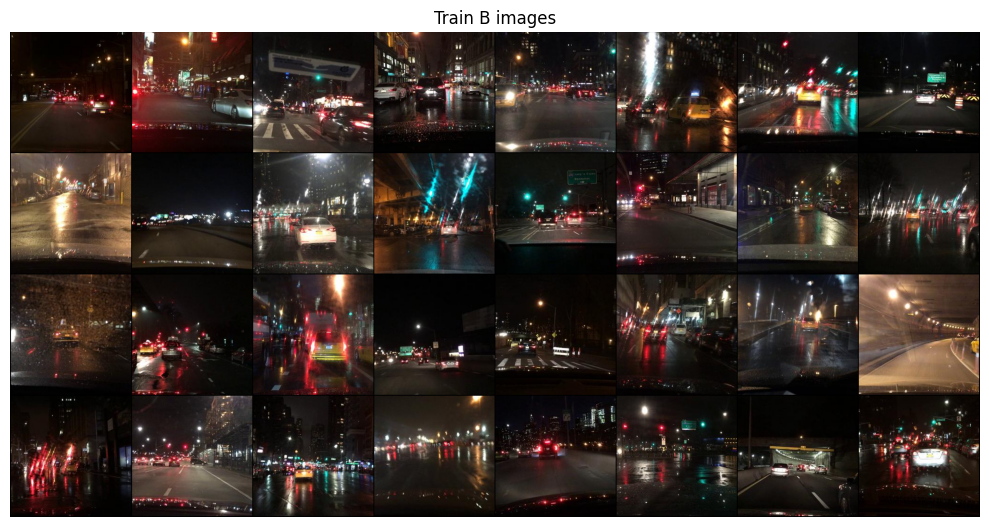

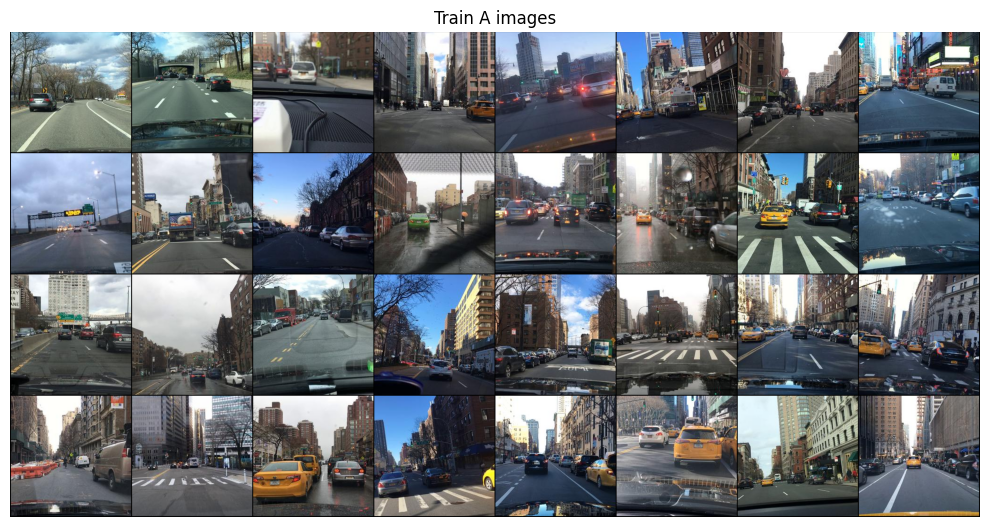

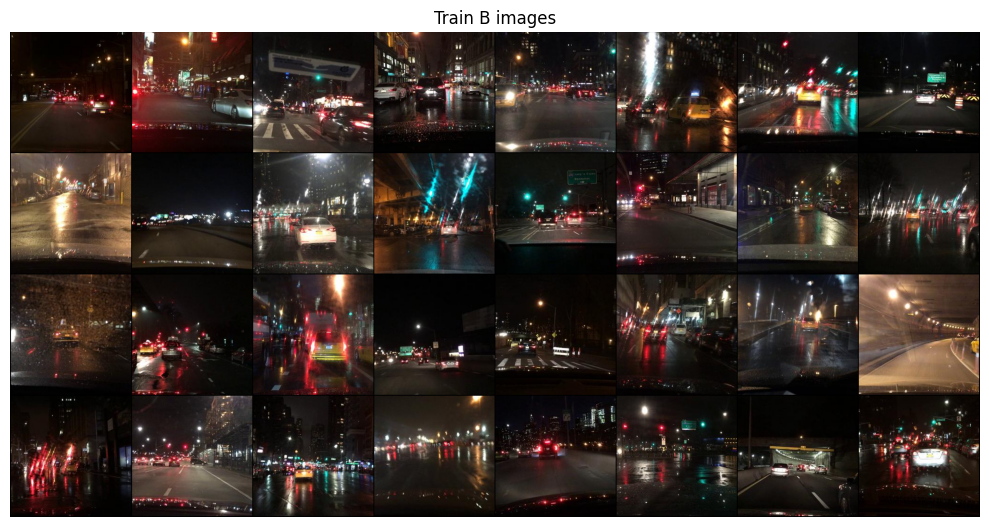

In [64]:
train_A = get_img_dataloader(
            csv_file=train_A_csv,
            img_dir=Path(train_A_csv).parent / Path(train_A_csv).stem.replace('_train', ''),
            transformation=None,
            file_name_col='file_name',
            batch_size=32,
            shuffle=True,
            num_workers=4)

n_imgs = len(pd.read_csv(train_A_csv)) - 1
n_batches = np.ceil(n_imgs / 32)

imgs = next(iter(train_A))

shp = imgs.shape

print(f'Batch size should be {shp[0]}.\n')
batch_size = shp[0]

print(f'Number of channels should be {shp[1]}.')
n_channels = shp[1]

print(f'Image height should be {shp[2]}.')
print(f'Image width should be {shp[3]}.')

img_dim = 256

show_img(imgs, title='Train A images', figsize = (10, 6))

train_B = get_img_dataloader(
    csv_file=train_B_csv,
    img_dir=Path(train_B_csv).parent / Path(train_B_csv).stem.replace('_train', ''))

imgs = next(iter(train_B))
show_img(imgs, title='Train B images', figsize = (10, 6))


# Training

## Hyperparameters

In [65]:
hyperparameters = {
	"latent_dim" : 100,
	"num_epochs" : 100,
	"batch_size" : batch_size,
	"device" : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
	"lr" : 0.0002,
	"b1" : 0.5,
	"b2" : 0.999,
	"n_cpu" : 8,
	"img_size" : 256,
	"channels" : n_channels,
	"sample_interval" : 100,
	"checkpoint_interval" : 10,
}

## Helper functions

In [66]:
%pip install -qU wandb

Note: you may need to restart the kernel to use updated packages.


In [67]:
from tqdm import tqdm
import wandb

wandb.init(project="cyclegan", config=hyperparameters)

In [68]:
def save_model(model, local_path='model.pth', wandb_log=True):
    """
    Saves the model state to a local file and optionally logs it to Weights & Biases (WandB).

    Args:
    - model (torch.nn.Module): The model instance to save.
    - local_path (str): The file path where the model will be saved locally. Defaults to 'model.pth'.
    - wandb_log (bool): Whether to log the model to WandB for version control and experiment tracking. Defaults to True.

    Saves:
    - A checkpoint of the model's state dictionary to the specified local file.
    - If `wandb_log` is True, the model will also be saved to WandB for remote logging.
    """
    # Save locally
    torch.save(model.state_dict(), local_path)

    # Save to WandB
    if wandb_log:
        wandb.save(local_path)

def save_losses(loss_G, loss_D_A, loss_D_B, filename='losses.txt'):
    """
    Saves the generator and discriminator losses to a text file.

    Args:
    - loss_G (list): List of generator losses over the training epochs.
    - loss_D_A (list): List of discriminator A losses over the training epochs.
    - loss_D_B (list): List of discriminator B losses over the training epochs.
    - filename (str): The file path where the losses will be saved. Defaults to 'losses.txt'.

    Saves:
    - A text file containing the losses for the generator and discriminators (A and B) over the training epochs.
    """
    np.savetxt(filename, np.column_stack((loss_G, loss_D_A, loss_D_B)), header='Generator total loss, Discriminator A loss, Discriminator B loss')

def train_one_epoch(epoch, model, train_A, train_B, device):
    """
    Trains the CycleGAN model for a single epoch and returns the generator and discriminator losses.

    Args:
    - epoch (int): The current epoch number.
    - model (CycleGAN): The CycleGAN model instance.
    - train_A (DataLoader): DataLoader for domain A training images.
    - train_B (DataLoader): DataLoader for domain B training images.
    - device (torch.device): The device on which the model and data are loaded (e.g., 'cuda' or 'cpu').

    Returns:
    - loss_G (float): The total loss of the generator for this epoch.
    - loss_D_A (float): The total loss of discriminator A for this epoch.
    - loss_D_B (float): The total loss of discriminator B for this epoch.

    During training:
    - It iterates through the batches of both domains (A and B) and performs optimization on the generators and discriminators.
    - Progress is tracked with a `tqdm` progress bar that shows current generator and discriminator losses.
    """

    progress_bar = tqdm(zip(train_A, train_B), desc=f'Epoch {epoch:03d}', leave=False)

    for batch_A, batch_B in progress_bar:
        real_A = batch_A[0].to(device)
        real_B = batch_B[0].to(device)

        # Perform one optimization step
        loss_G, loss_D_A, loss_D_B = model.optimize(real_A, real_B)

        progress_bar.set_postfix({
            'G_loss': f'{loss_G:.4f}',
            'D_A_loss': f'{loss_D_A:.4f}',
            'D_B_loss': f'{loss_D_B:.4f}'
        })

    return loss_G, loss_D_A, loss_D_B

# Plot losses
def plot_losses(train_losses_G, train_losses_D_A, train_losses_D_B):
    """
    Plots the training losses for the generator and the discriminators (D_A and D_B) over the epochs.

    Args:
    - train_losses_G (list): List of generator losses over the epochs.
    - train_losses_D_A (list): List of discriminator A losses over the epochs.
    - train_losses_D_B (list): List of discriminator B losses over the epochs.

    Displays:
    - A line plot showing the progression of generator and discriminator losses over time.
    - Losses are plotted against the number of epochs.
    """
    epochs = range(1, len(train_losses_G) + 1)

    plt.plot(epochs, train_losses_G, label='Generator Loss', linewidth=2, alpha=0.7)
    plt.plot(epochs, train_losses_D_A, label='Discriminator A Loss', linewidth=2, alpha=0.7)
    plt.plot(epochs, train_losses_D_B, label='Discriminator B Loss', linewidth=2, alpha=0.7)

    plt.title('CycleGAN Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Training loop

The training loop includes the following steps:

1. **Generate fake images** from the generators.
2. **Compute adversarial loss** for both discriminators and generators.
3. **Cycle loss** to ensure image reconstruction.
4. **Identity loss** to preserve image identity during translation.
5. Update the **discriminator and generator** weights using backpropagation.

In [69]:
cycle_gan = CycleGAN(
            input_nc=hyperparameters["channels"],
            output_nc=hyperparameters["channels"],
            device=hyperparameters["device"],
            n_features=hyperparameters["n_features"],
            n_residual_blocks=hyperparameters["n_residual_blocks"],
            n_downsampling=hyperparameters["n_downsampling"],
            cycle_loss_weight=hyperparameters["cycle_loss_weight"],
            id_loss_weight=hyperparameters["id_loss_weight"],
            lr=hyperparameters["lr"],
            beta1=hyperparameters["beta1"],
            beta2=hyperparameters["beta2"],
        )

In [ ]:
train_losses_G, train_losses_D_A, train_losses_D_B = [], [], []

for epoch in range(hyperparameters["num_epochs"]):
    loss_G, loss_D_A, loss_D_B = train_one_epoch(epoch=epoch, model=cycle_gan, train_A=train_A, train_B=train_B, device=hyperparameters["device"])

    avg_loss_G   = loss_G / len(train_A)
    avg_loss_D_A = loss_D_A / len(train_A)
    avg_loss_D_B = loss_D_B / len(train_B)

    train_losses_G.append(avg_loss_G)
    train_losses_D_A.append(avg_loss_D_A)
    train_losses_D_B.append(avg_loss_D_B)

    # Save the average losses to a file
    save_losses(train_losses_G, train_losses_D_A, train_losses_D_B)

    if epoch % hyperparameters["checkpoint_interval"] == 0:
        save_model(epoch, cycle_gan, local_path=f'cycle_gan_epoch_{epoch}.pth', wandb_log=True)

    wandb.log({
        'G_loss/train': avg_loss_G,
        'D_A_loss/train': avg_loss_D_A,
        'D_B_loss/train': avg_loss_D_B,
    })

## Verifying the losses

In [ ]:
losses = np.loadtxt('losses.txt')

# Extract the generator and discriminator losses
train_losses_G = losses[:, 0]  # First column: Generator loss
train_losses_D_A = losses[:, 1]  # Second column: Discriminator A loss
train_losses_D_B = losses[:, 2]  # Third column: Discriminator B loss

plot_losses(train_losses_G, train_losses_D_A, train_losses_D_B)